<a href="https://colab.research.google.com/github/RtemShcherbak/Homeworks/blob/main/%D0%94%D0%97%E2%84%967_%D0%A9%D0%B5%D1%80%D0%B1%D0%B0%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Загрузка библиотек

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00


In [ ]:
!pip install -qq Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 819.7 kB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, BertModel, BertPreTrainedModel, BertForSequenceClassification

from tqdm import tqdm
import gc
import os

import torch
import torch.nn as nn
import torchmetrics
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla V100-SXM2-16GB GPUs


# 1.Загрузка данных

## 1.1 Установка ключа и скачивание данных

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!rm -rf /content/kuc-hackathon-winter-2018.zip

In [ ]:
! kaggle datasets download jessicali9530/kuc-hackathon-winter-2018

 84% 34.0M/40.7M [00:00<00:00, 118MB/s]
100% 40.7M/40.7M [00:00<00:00, 132MB/s]


In [ ]:
!unzip kuc-hackathon-winter-2018.zip

Archive:  kuc-hackathon-winter-2018.zip
  inflating: drugsComTest_raw.csv    
  inflating: drugsComTrain_raw.csv   


# 2.Config

In [ ]:
#-----Model Configurations-----#
MAX_LEN_STRING = 350

MAX_LEN_TRAIN = 500
MAX_LEN_VALID = 500
MAX_LEN_TEST = 500
NUM_THREADS = 2

BATCH_SIZE = 32
LR = 1e-5
NUM_EPOCHS = 10
MODEL_NAME = 'distilbert-base-uncased'

# 3.Подготовка данных

In [ ]:
test_text = pd.read_csv('drugsComTest_raw.csv')
train_text = pd.read_csv('drugsComTrain_raw.csv')

train_text['rating'] = train_text['rating'].map(lambda x: x - 1)
test_text['rating'] = test_text['rating'].map(lambda x: x - 1)

In [ ]:
train_text.head(5)

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",8,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",7,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",4,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",7,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",8,27-Nov-16,37


## 3.1 Проверка длины текста

In [ ]:
train_text['len'] = train_text['review'].map(lambda x: x.count(" "))
test_text['len'] = test_text['review'].map(lambda x: x.count(" "))

In [ ]:
train_text['len'].describe()

count    161297.000000
mean         84.646788
std          45.507389
min           0.000000
25%          48.000000
50%          84.000000
75%         126.000000
max        1856.000000
Name: len, dtype: float64

In [ ]:
test_text['len'].describe()

count    53766.000000
mean        84.587751
std         44.767313
min          0.000000
25%         48.000000
50%         84.000000
75%        126.000000
max       1221.000000
Name: len, dtype: float64

<Axes: xlabel='len', ylabel='Count'>

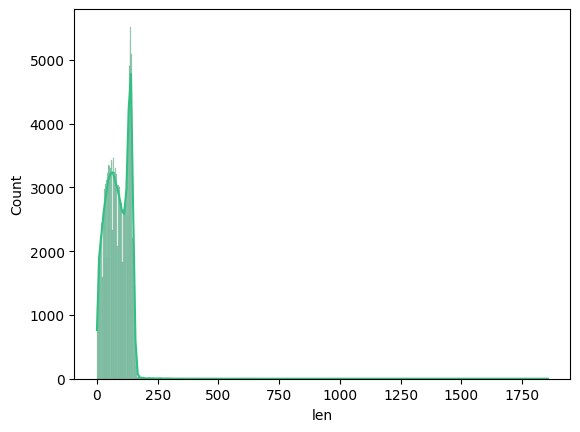

In [ ]:
import seaborn as sns
sns.histplot(train_text['len'], color=sns.xkcd_rgb['greenish teal'], kde=True)

> Большая часть отзывов имеет длину около 200 слов

## 3.2 Очистка данных

In [ ]:
test_text['review'] = test_text['review'].str.replace('[^\w\s]', '')
train_text['review'] = train_text['review'].str.replace('[^\w\s]', '')

<ipython-input-19-67bfb26622cb>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_text['review'] = test_text['review'].str.replace('[^\w\s]', '')
<ipython-input-19-67bfb26622cb>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_text['review'] = train_text['review'].str.replace('[^\w\s]', '')


## 3.3 Токенизация

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,
                                          do_lower_case=True,
                                          max_length='max_length',
                                          padding='post',
                                          truncation=True)

In [ ]:
def tokenize_function(df: pd.DataFrame):
  '''
  Функция возвращает кортеж из токенов и attention mask

  :param df: путь к директории с датасетом
  :type df: pd.DataFrame

  :raises None

  :rtype: tuple
  :return: (input_ids, attention_mask)
  '''
  tokens = tokenizer(df,
                     padding='max_length',
                     truncation=True,
                     max_length=MAX_LEN_STRING)
  return tokens.input_ids, tokens.attention_mask

def preprocessing(df: pd.DataFrame,
                  inputs: str,
                  target: str):
    '''
  Функция возвращает кортеж из токенов и attention mask

  :param df: путь к директории с датасетом
  :type df: pd.DataFrame

  :raises None

  :rtype: pd.DataFrame
  :return: датафрейм с токенизированным текстом и масками
  '''
  cols = list(df.columns)
  try:
    cols.remove(target)
    cols.remove(inputs)
  except:
    print('Enter right names')
  df['input_ids'] = df[inputs].apply(lambda x: tokenize_function(x)[0])
  df['attention_mask'] = df[inputs].apply(lambda x: tokenize_function(x)[1])
  return df.drop(columns=cols, axis=1)

def convert_str_to_list(strng: str):
  '''
  Функция переводит строку с числами в массив np.arrat

  :param strng: строка, содеражащая числа
  :type strng: str

  :raises None

  :rtype: numpy.array
  :return: массив с числами
  '''
  strng = strng.strip('][').split(', ')
  lst = [int(i) for i in strng]
  return np.array(lst)

 Чтобы не тратить время на токенизацию каждый раз при запуске блокнота, код ниже сохраняет токенизированный текст в .csv формате и при последующих запусках предлагает выбор: токенизировать текст заново или загрузить токены из существующего файла

In [ ]:
ans = str(input('Re-tokenize text - y/n: '))
if ans == 'y':
  train_text = preprocessing(df=train_text, inputs='review', target='rating')
  test_text = preprocessing(df=test_text, inputs='review', target='rating')
  train_text.to_csv('/content/drive/MyDrive/Models/hw_7/train_text.csv', sep='\t')
  test_text.to_csv('/content/drive/MyDrive/Models/hw_7/test_text.csv', sep='\t')
elif ans == 'n':
  train_text = pd.read_csv('/content/drive/MyDrive/Models/hw_7/train_text.csv', sep='\t')
  test_text = pd.read_csv('/content/drive/MyDrive/Models/hw_7/test_text.csv', sep='\t')
  train_text['input_ids'], train_text['attention_mask'] = train_text['input_ids'].apply(convert_str_to_list), train_text['attention_mask'].apply(convert_str_to_list)
  test_text['input_ids'], test_text['attention_mask'] = test_text['input_ids'].apply(convert_str_to_list), test_text['attention_mask'].apply(convert_str_to_list)

Re-tokenize text - y/n: n


In [ ]:
print(type(train_text['input_ids'][0]))

<class 'numpy.ndarray'>


In [ ]:
train_data, validation_data = train_test_split(train_text, random_state=42, test_size=0.2)

In [ ]:
train_labels = np.array([[int(rating)] for rating in train_data['rating']])
train_inputs = np.array([input_ids for input_ids in train_data['input_ids']])
train_masks = np.array([masks for masks in train_data['attention_mask']])

validation_labels = np.array([[int(rating)] for rating in validation_data['rating']])
validation_inputs = np.array([input_ids for input_ids in validation_data['input_ids']])
validation_masks = np.array([masks for masks in validation_data['attention_mask']])

test_labels = np.array([[int(rating)] for rating in test_text['rating']])
test_inputs = np.array([input_ids for input_ids in test_text['input_ids']])

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

test_labels = torch.tensor(test_labels)
test_inputs = torch.tensor(test_inputs)

## 3.4 DataLoader

In [ ]:
train_tensor_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_tensor_dataset,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_tensor_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_tensor_dataset,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

# 4.Train function

In [ ]:
class MetricMonitor:
    """
    Класс служит для хранения метрик, полученных в процессе обучения


    Attributes
    ----------
    float_precision : int
        точность результата

    Methods
    -------
    reset
        создаёт словарь со значениями метрики: текущем, среднем и счётчик значений
    update
        обновляет словарь метрики
    """

    def __init__(self, float_precision=5):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        """
        :param metric_name: имя метрики
        :type metric_name: str

        :param val: мгновенное значение метрики
        :type val: float

        :raises None

        :rtype: None
        :return: None
        """

        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

    def get_average_loss(self):
      return self.metrics['Loss']['avg']

In [ ]:
def train(model, train_loader, validation_loader, criterion, optimizer, name=None, n_epoch=5):
    best_loss = 1e+6
    previous_pth = None

    for epoch in range(n_epoch):

        model.train()
        stream = tqdm(train_loader)
        metric_monitor = MetricMonitor()
        for step, batch in enumerate(stream):
           batch = tuple(t.to(device) for t in batch)
           t_input_ids, t_attention_mask, t_target = batch

           #output = model(input_ids=t_input_ids, attention_mask=t_attention_mask)
           outputs = model(input_ids=t_input_ids, attention_mask=t_attention_mask, labels=t_target).logits
           loss = criterion(outputs, t_target.type_as(outputs))
           #loss = criterion(output, target.type_as(output))
           metric_monitor.update('Loss', loss.item())

           optimizer.zero_grad()
           loss.backward()
           optimizer.step()

           stream.set_description(
              "Epoch: {epoch}. Train.      {metric_monitor} || instant_loss: {loss}".format(epoch=epoch, metric_monitor=metric_monitor, loss=loss.item())
              )

        train_loss = metric_monitor.get_average_loss()
        if train_loss < best_loss and name != None:
          print('save_train | ' + str(metric_monitor) + ' | ' + str(loss.item()) + ' \n')
          if previous_pth != None:
            os.remove(previous_pth)
          new_pth = '/content/drive/MyDrive/Models/hw_7/' + f"__train__{name}__{metric_monitor}_epoch--{epoch}" + '.pt'
          torch.save(model.state_dict(), new_pth)
          best_loss = train_loss
          previous_pth = new_pth

        model.eval()
        stream1 = tqdm(validation_loader)
        metric_monitor1 = MetricMonitor()
        with torch.no_grad():
          for i, batch in enumerate(stream1):
            batch = tuple(t.to(device) for t in batch)
            v_input_ids, v_attention_mask, v_target = batch

            #output = model(input_ids=v_input_ids, attention_mask=v_attention_mask)
            outputs = model(input_ids=v_input_ids, attention_mask=v_attention_mask, labels=v_target).logits

            loss = criterion(outputs, v_target)
            metric_monitor1.update('Loss', loss.item())
            stream1.set_description(
                "Epoch: {epoch}. Test.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor1)
                )

          val_loss = metric_monitor1.get_average_loss()
          if name != None:
            print('save_val | ' + str(metric_monitor1) + ' | ' + str(loss.item()) + ' \n')
            if previous_pth != None:
              os.remove(previous_pth)
            new_pth = '/content/drive/MyDrive/Models/hw_7/' + f"__val__{name}__{metric_monitor1}_epoch--{epoch}" + '.pt'
            torch.save(model.state_dict(), new_pth)
            best_loss = val_loss
            previous_pth = new_pth

    print('Обучение закончено')
    return model

# 5.Model

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/hw_7/__val__i-bert__Loss: 1.32902_epoch--4.pt',
                                 map_location=torch.device(device)))
model.to(device)
pass

## 5.1 Optimizer

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR)

## 5.2 Criterion

In [ ]:
criterion = nn.MSELoss()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

## 5.3 Train

In [ ]:
trained_model = train(model, train_dataloader, validation_dataloader, criterion, optimizer, name='i-bert', n_epoch=NUM_EPOCHS)

Epoch: 0. Train.      Loss: 0.28999 || instant_loss: 0.1408577561378479: 100%|██████████| 4033/4033 [1:33:35<00:00,  1.39s/it]


save_train | Loss: 0.28999 | 0.1408577561378479 



Epoch: 0. Test.      Loss: 1.36062: 100%|██████████| 1009/1009 [08:41<00:00,  1.93it/s]


save_val | Loss: 1.36062 | 0.49381113052368164 



Epoch: 1. Train.      Loss: 0.27383 || instant_loss: 0.2614695727825165: 100%|██████████| 4033/4033 [1:34:00<00:00,  1.40s/it]


save_train | Loss: 0.27383 | 0.2614695727825165 



Epoch: 1. Test.      Loss: 1.33710: 100%|██████████| 1009/1009 [08:41<00:00,  1.93it/s]


save_val | Loss: 1.33710 | 0.3109072744846344 



Epoch: 2. Train.      Loss: 0.26009 || instant_loss: 0.32740429043769836: 100%|██████████| 4033/4033 [1:34:00<00:00,  1.40s/it]


save_train | Loss: 0.26009 | 0.32740429043769836 



Epoch: 2. Test.      Loss: 1.33522: 100%|██████████| 1009/1009 [08:42<00:00,  1.93it/s]


save_val | Loss: 1.33522 | 0.5182997584342957 



Epoch: 3. Train.      Loss: 0.25063 || instant_loss: 0.22451704740524292: 100%|██████████| 4033/4033 [1:34:05<00:00,  1.40s/it]


save_train | Loss: 0.25063 | 0.22451704740524292 



Epoch: 3. Test.      Loss: 1.36278: 100%|██████████| 1009/1009 [08:42<00:00,  1.93it/s]


save_val | Loss: 1.36278 | 0.3687218129634857 



Epoch: 4. Train.      Loss: 0.23397 || instant_loss: 0.19308513402938843:  37%|███▋      | 1480/4033 [34:32<59:38,  1.40s/it]

# 6.Test


In [ ]:
model.to(device)
model.eval()
out = []
target = []

stream1 = tqdm(validation_dataloader)
metric_monitor1 = MetricMonitor()
with torch.no_grad():
  for i, batch in enumerate(stream1):
    batch = tuple(t.to(device) for t in batch)
    v_input_ids, v_attention_mask, v_target = batch

    #output = model(input_ids=v_input_ids, attention_mask=v_attention_mask)
    outputs = model(input_ids=v_input_ids, attention_mask=v_attention_mask, labels=v_target).logits
    out.append(outputs.cpu().detach().numpy()[0][0])
    target.append(v_target.cpu().detach().numpy()[0][0])
    loss = criterion(outputs, v_target)
    metric_monitor1.update('Loss', loss.item())
    stream1.set_description(
        "Epoch: {epoch}. Test.      {metric_monitor}".format(epoch=0, metric_monitor=metric_monitor1)
        )

Epoch: 0. Test.      Loss: 1.32902: 100%|██████████| 1009/1009 [02:30<00:00,  6.73it/s]


Для визуальной оценки ошибки, результаты работы модели представлены в DataFrame. Колонка "out" - ответ модели, колонка "target" - рейтинг из исходного датафрейма, колонка "error" - абсолютная разница между ними.

In [ ]:
to_df = {'out': out, 'target': target}
df = pd.DataFrame(to_df)
df['out'] = df['out'].map(lambda x: round(x, ndigits=2))
df['error'] = ((df['out'] - df['target']) ** 2) ** (1/2)
df

,out,target,error
0,8.95,9,0.05
1,7.24,7,0.24
2,8.86,8,0.86
3,6.76,6,0.76
4,8.80,9,0.20
...,...,...,...
1004,1.82,2,0.18
1005,0.08,0,0.08
1006,4.53,5,0.47
1007,0.49,1,0.51


In [ ]:
df['error'].describe()

count    1009.000000
mean        0.617968
std         0.850829
min         0.000000
25%         0.080000
50%         0.290000
75%         0.820000
max         7.970000
Name: error, dtype: float64

#7.Вывод

Для реализации прогноза rating на основе колонки review была применена модель dictilbert. Полученный Loss = 1.33